# Parametric shape optimization with differentiable FEM simulation

## Introduction

In this notebook, we explore the optimization of a parametric structure made of a linear elastic material.

We denote the design space as a function $g$ that maps the design variables to a signed distance field. Then, we can then define the density field $\rho(\mathbf{x})$ as a function of a signed distance field (SDF) value $g(\mathbf{x})$. For adaptive meshing, we define a sizing field $h(\mathbf{x})$ as a function of the SDF value as well.
We introduce an adpative differentiable mesher $m$ that takes the sizing field and returns a hex mesh. Finally we denote the differentiable finite element method (FEM) solver as $f$, which takes the density field and the hex mesh as input and returns the structure's compliance.  Therefore, the optimization problem can be formulated as follows:

$$
\begin{equation}
\min_{\theta} f(m(g(\theta)), \rho(g(\theta))).
\end{equation}
$$

Here, $\theta$ is the vector of design variables.

## Setup

In [26]:
# Install additional requirements for this notebook
# %pip install -r requirements.txt -q --isolated

In [27]:
# import tesseract_core

# tesseract_core.build_tesseract("design_tess", "latest")
# tesseract_core.build_tesseract("fem_tess", "latest")
# tesseract_core.build_tesseract("meshing_tess", "latest")
# print("Tesseract built successfully.")

## Design Space Tesseract

In [35]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import pyvista as pv
from tesseract_core import Tesseract
from tesseract_core.runtime.experimental import TesseractReference

from tesseract_jax import apply_tesseract

In [36]:
# design_tess = Tesseract.from_image("design-tube-sdf")
# design_tess.serve()
IP = "172.26.3.35"
port = 443
url = f"http://{IP}:{port}"

design_tess = Tesseract.from_tesseract_api("sdf_fd_tess/tesseract_api.py")
stl_tess = Tesseract.from_url(url)
# stt_tess = Tesseract.from_tesseract_api("bars_3d_tess/tesseract_api.py")

Now we can setup the parameters for the design space and apply the design Tesseract. The Tesseract constructs a 3D geometry using PyVista and computes its signed distance field (SDF).

In [37]:
Nx, Ny, Nz = 250, 200, 10
Lx, Ly, Lz = 50, 40, 2

grid_fin_params = {
    "angular_positions": jnp.array(
        [
            [0, 3.14],
            [0.39, 3.53],
            [0.79, 3.93],
            [1.18, 4.32],
            [1.57, 4.71],
            [1.96, 5.11],
            [2.36, 5.50],
            [2.75, 5.89],
        ]
    ),
    "plane_height": 400,
    "plane_thickness": 100,
    "cuttin_plane_1": 200,
    "cuttin_plane_2": 200,
}

# lets create a flat parameter array from the grid fin params
init_diffable_params = jnp.concatenate(
    [
        jnp.array(
            [grid_fin_params["cuttin_plane_1"], grid_fin_params["cuttin_plane_2"]]
        ),
        grid_fin_params["angular_positions"].flatten(),
    ]
).astype(jnp.float32)

normalization_factors = 1 / jnp.array([1000, 1000] + [3.14 * 2] * 16, dtype=jnp.float32)
normalization_bias = jnp.zeros_like(normalization_factors)


def normalize(params, norms, bias):
    return params * norms + bias


def denormalize(params, norms, bias):
    return (params - bias) / norms


init_diffable_params = normalize(
    init_diffable_params, normalization_factors, normalization_bias
)

non_diffable_paramas = jnp.array(
    [
        grid_fin_params["plane_height"],
        grid_fin_params["plane_thickness"],
    ],
    dtype=jnp.float32,
)

design_inputs = {
    "non_differentiable_parameters": non_diffable_paramas,
    "normalization_factors": normalization_factors,
    "normalization_bias": normalization_bias,
    "static_parameters": [],
    "string_parameters": [
        "F:\\ANSYS Inc\\v242\\scdm\\SpaceClaim.exe",
        "geometry_generation.scscript",
    ],
    "mesh_tesseract": TesseractReference(stl_tess),
    "grid_center": [0.0, 0.0, 2.0],
    "grid_size": [Lx, Ly, Lz],
    "grid_elements": [Nx, Ny, Nz],
    "scale_mesh": 0.01,
    "max_points": 1000,
    "max_faces": 2000,
    "precompute_jacobian": True,
    "normalize_jacobian": False,
    "sdf_backend": "pyvista",
    "epsilon": 0.001,
}

print(init_diffable_params)

[0.2        0.2        0.         0.49999997 0.0621019  0.56210184
 0.12579617 0.62579614 0.18789807 0.68789804 0.24999999 0.74999994
 0.3121019  0.81369424 0.37579614 0.8757961  0.43789804 0.937898  ]


In [ ]:
design_out = apply_tesseract(
    design_tess,
    {
        "differentiable_parameters": init_diffable_params,
        **design_inputs,
    },
)
sdf = design_out["sdf"]
surface_mesh = design_out["mesh"]

num_vertices = surface_mesh["n_points"]
num_faces = surface_mesh["n_faces"]

print(f"Number of vertices: {num_vertices}")
print(f"Number of faces: {num_faces}")

points = surface_mesh["points"][:num_vertices]
faces = surface_mesh["faces"][:num_faces]

mesh = {
    "points": points,
    "faces": faces,
}

## Lets investigate the jacobian that was produced using finite differences

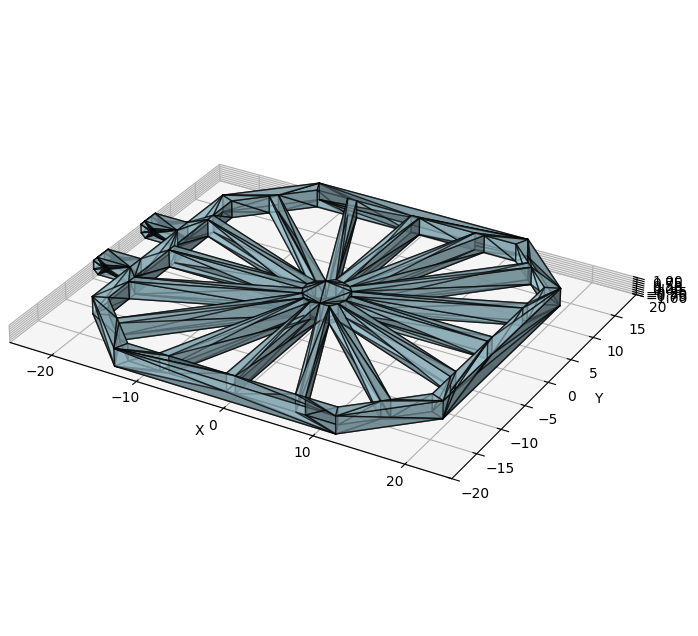

In [32]:
def plot_mesh(mesh: dict, save_path: str | None = None) -> None:
    """Plot a 3D triangular mesh with boundary conditions visualization.

    Args:
        mesh: Dictionary containing 'points' and 'faces' arrays.
        save_path: Optional path to save the plot as an image file.
    """
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection="3d")
    ax.plot_trisurf(
        mesh["points"][:, 0],
        mesh["points"][:, 1],
        mesh["points"][:, 2],
        triangles=mesh["faces"],
        alpha=0.7,
        antialiased=True,
        color="lightblue",
        edgecolor="black",
    )

    ax.set_xlim(-Lx / 2, Lx / 2)
    ax.set_ylim(-Ly / 2, Ly / 2)
    ax.set_zlim(-Lz / 2, Lz / 2)

    # set equal aspect ratio
    ax.set_box_aspect(
        (
            (Lx) / (Ly),
            1,
            (Lz) / (Ly),
        )
    )

    # x axis label
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")

    if save_path:
        # avoid showing the plot in notebook
        plt.savefig(save_path)
        plt.close(fig)


plot_mesh(mesh)

In [33]:
# # Lets figure out a good epsilon value for FD jacobian computation
# epsilons = jnp.logspace(-2, -0.5, 5)
# print(epsilons)
# mean_grads = []
# std_grads = []

# for i in range(len(epsilons)):
#     eps = epsilons[i]
#     print(eps)
#     design_inputs_eps = design_inputs.copy()
#     design_inputs_eps["epsilon"] = eps.item()

#     primal, vjp_fun = jax.vjp(
#         lambda params, design_params=design_inputs_eps: apply_tesseract(
#             design_tess,
#             {
#                 "differentiable_parameters": params,
#                 **design_params,
#             },
#         )["sdf"],
#         init_diffable_params,
#     )

#     grad = vjp_fun(jnp.ones((Nx, Ny, Nz), dtype=jnp.float32))[0]

#     mean_grads.append(jnp.mean(jnp.abs(grad)))
#     std_grads.append(jnp.std(grad))

In [34]:
# plt.figure(figsize=(8, 6))
# plt.plot(epsilons, mean_grads, marker="o")
# plt.plot(epsilons, std_grads, marker="x")
# plt.xlabel("Epsilon")
# plt.xscale("log")
# plt.yscale("log")
# plt.ylabel("Mean Absolute Gradient")
# plt.title("Effect of Epsilon on Gradient Magnitude")
# plt.grid(True)
# plt.legend(["Mean Gradient", "Std Dev of Gradient"])

In [35]:
# primal, vjp_fun = jax.vjp(
#     lambda params: apply_tesseract(
#         design_tess,
#         {
#             "differentiable_parameters": params,
#             **design_inputs,
#         },
#     )["sdf"],
#     init_diffable_params,
# )

# grad = vjp_fun(jax.numpy.ones((Nx, Ny, Nz), dtype=jax.numpy.float32))[0]

# print("Gradient shape:", grad.shape)

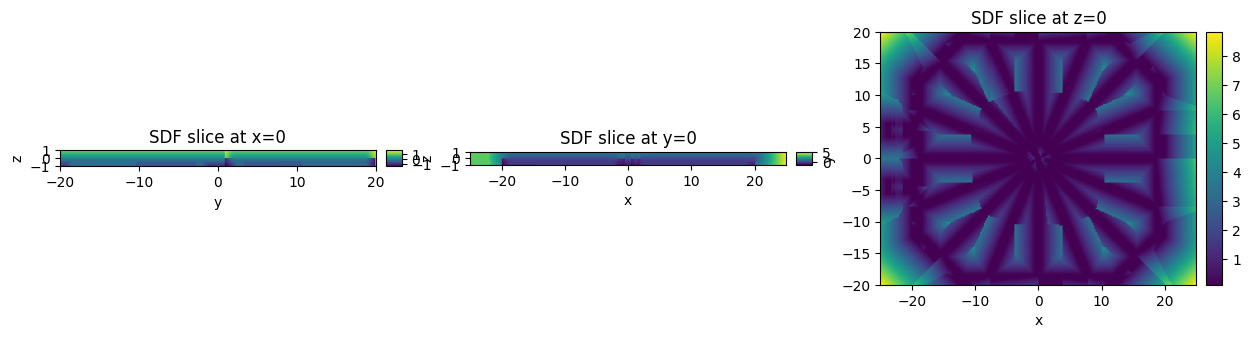

In [23]:
from mpl_toolkits.axes_grid1 import make_axes_locatable


def plot_grid_slice(field_slice, extent, ax, title, xlabel, ylabel):
    im = ax.imshow(field_slice.T, extent=extent, origin="lower")
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    # add colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    plt.colorbar(im, cax=cax, orientation="vertical")
    return im


def plot_grid(field, Lx, Ly, Lz, Nx, Ny, Nz):
    _, axs = plt.subplots(1, 3, figsize=(15, 5))

    plot_grid_slice(
        field[Nx // 2, :, :],
        extent=(-Ly / 2, Ly / 2, -Lz / 2, Lz / 2),
        ax=axs[0],
        title="SDF slice at x=0",
        xlabel="y",
        ylabel="z",
    )
    plot_grid_slice(
        field[:, Ny // 2, :],
        extent=(-Lx / 2, Lx / 2, -Lz / 2, Lz / 2),
        ax=axs[1],
        title="SDF slice at y=0",
        xlabel="x",
        ylabel="z",
    )
    plot_grid_slice(
        field[:, :, Nz // 2],
        extent=(-Lx / 2, Lx / 2, -Ly / 2, Ly / 2),
        ax=axs[2],
        title="SDF slice at z=0",
        xlabel="x",
        ylabel="y",
    )


plot_grid(sdf, Lx, Ly, Lz, Nx, Ny, Nz)

In [ ]:
result = design_tess.jacobian(
    inputs={
        "differentiable_parameters": init_diffable_params,
        **design_inputs,
    },
    jac_inputs=["differentiable_parameters"],
    jac_outputs=["sdf"],
)

(18, 250, 200, 10)


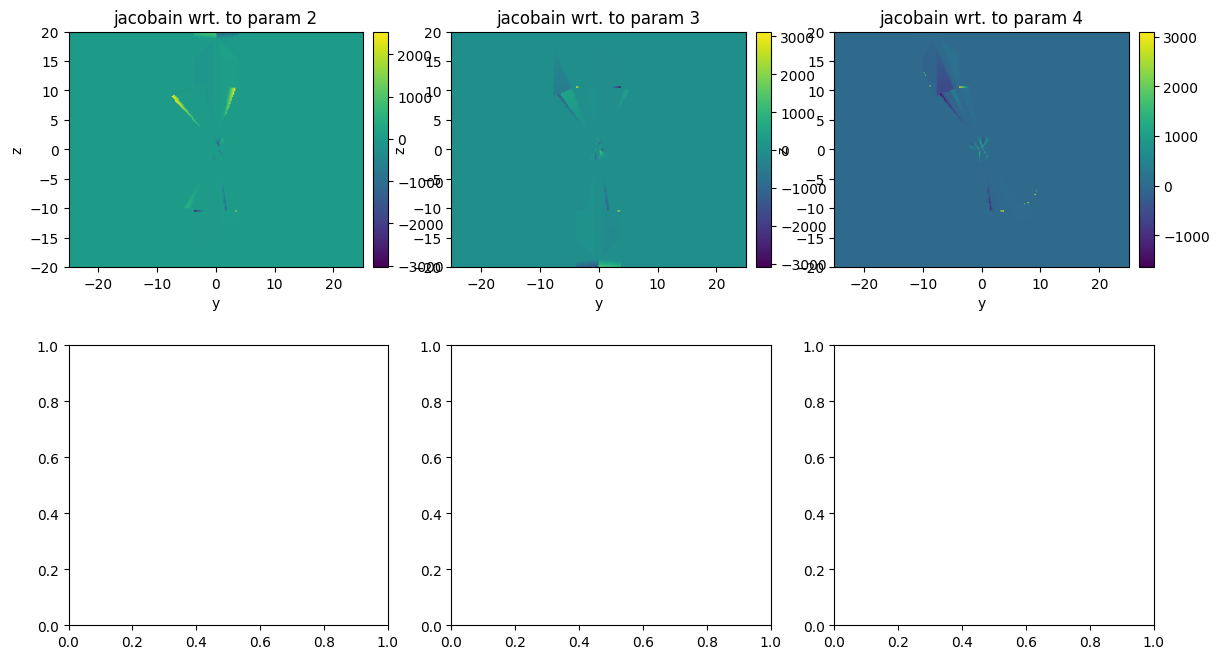

In [34]:
print(result["sdf"]["differentiable_parameters"].shape)
fig, axs = plt.subplots(2, 3, figsize=(14, 8))

plot_grid_slice(
    result["sdf"]["differentiable_parameters"][2][:, :, Nz // 2],
    extent=(-Lx / 2, Lx / 2, -Ly / 2, Ly / 2),
    ax=axs[0, 0],
    title="jacobain wrt. to param 2",
    xlabel="y",
    ylabel="z",
)

plot_grid_slice(
    result["sdf"]["differentiable_parameters"][3][:, :, Nz // 2],
    extent=(-Lx / 2, Lx / 2, -Ly / 2, Ly / 2),
    ax=axs[0, 1],
    title="jacobain wrt. to param 3",
    xlabel="y",
    ylabel="z",
)

plot_grid_slice(
    result["sdf"]["differentiable_parameters"][4][:, :, Nz // 2],
    extent=(-Lx / 2, Lx / 2, -Ly / 2, Ly / 2),
    ax=axs[0, 2],
    title="jacobain wrt. to param 4",
    xlabel="y",
    ylabel="z",
)

rho min: 7.189832558651688e-06, rho max: 0.9823046922683716


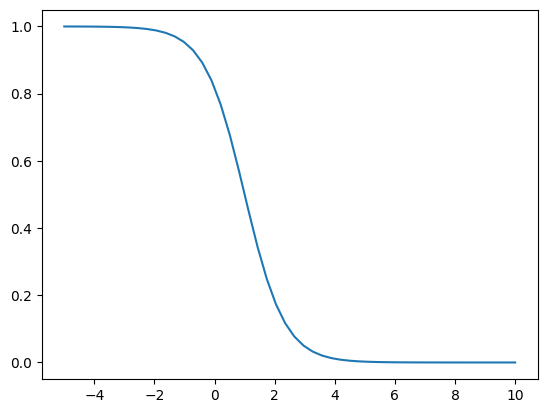

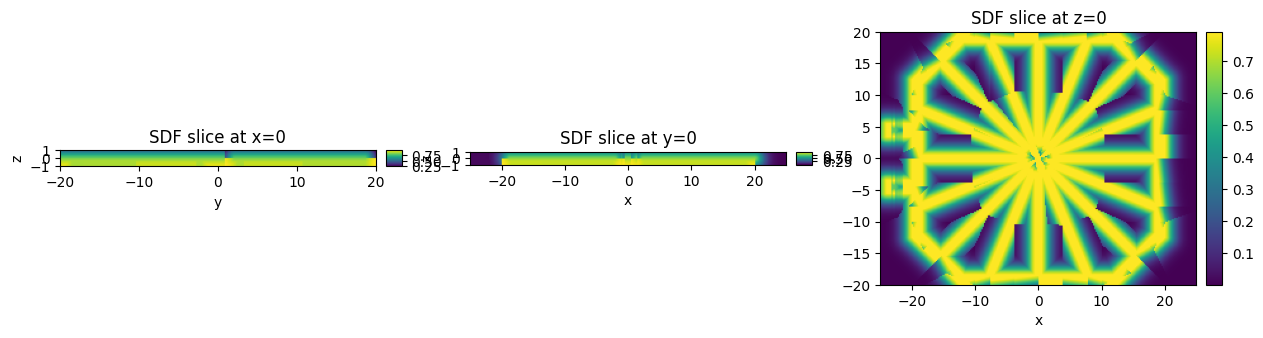

In [37]:
def sdf_to_rho(
    sdf: jnp.ndarray, scale: float = 2.0, offset: float = 0.1
) -> jnp.ndarray:
    """Convert signed distance function to material density using sigmoid.

    Args:
        sdf: Signed distance function values.
        scale: Sigmoid steepness (higher = sharper transition).
        offset: SDF value where density = 0.5.

    Returns:
        Material density field in [0,1].
    """
    return 1 / (1 + jnp.exp(scale * sdf - offset))


rho_scale = 1.5
rho_offset = 1.5

# plot the functions
sdfs = jnp.linspace(-5, 10)
rhos = sdf_to_rho(sdfs, scale=rho_scale, offset=rho_offset)

plt.plot(sdfs, rhos)


rho = sdf_to_rho(sdf, scale=rho_scale, offset=rho_offset)

plot_grid(rho, Lx, Ly, Lz, Nx, Ny, Nz)
print(f"rho min: {jnp.min(rho)}, rho max: {jnp.max(rho)}")

Sizing field min: 0.78125, max: 6.25


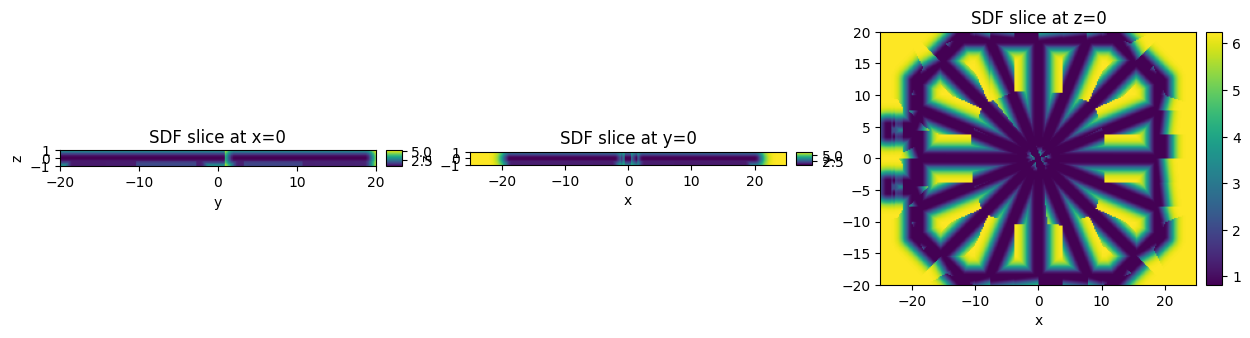

In [38]:
def sizing_field(
    sdf: jnp.ndarray, min_size: float = 0.1, max_size: float = 1.0, scale: float = 2.0
) -> jnp.ndarray:
    """Generate a sizing field from the signed distance function.

    The field is low (size = min_size) near the structure (sdf=0) and high (size = max_size) far from it.

    Args:
        sdf: Signed distance function values.
        min_size: Minimum element size near the structure.
        max_size: Maximum element size far from the structure.
        scale: Controls the transition steepness.

    Returns:
        Sizing field values.
    """

    def gauss(x: jnp.ndarray, mu: float, sigma: float) -> jnp.ndarray:
        return jnp.exp(-0.5 * ((x - mu) / sigma) ** 2)

    normalized_sdf = 1 - gauss(sdf, 0.0, 1.0 / scale)
    return min_size + (max_size - min_size) * normalized_sdf


sizing_min = Lx / 64
sizing_max = Lx / 8
sizing_scale = 1

sizing = sizing_field(sdf, min_size=sizing_min, max_size=sizing_max, scale=sizing_scale)
plot_grid(sizing, Lx, Ly, Lz, Nx, Ny, Nz)
print(f"Sizing field min: {sizing.min()}, max: {sizing.max()}")

In [39]:
mesher = Tesseract.from_tesseract_api("meshing_tess/tesseract_api.py")

mesher_out = apply_tesseract(
    mesher,
    {
        "domain_size": [Lx, Ly, Lz],
        "sizing_field": sizing,  # jnp.ones_like(sdf) * (Lx / 10),
        # "sizing_field": jnp.ones_like(sdf) * sizing_min,
        "field_values": rho,
        "max_subdivision_levels": 3,
        "max_points": 30000,
        "max_cells": 30000,
    },
)
print(
    f"Mesh points: {mesher_out['mesh']['n_points']}, Mesh faces: {mesher_out['mesh']['n_faces']}"
)
pts = mesher_out["mesh"]["points"][: mesher_out["mesh"]["n_points"]]
hex_cells = mesher_out["mesh"]["faces"][: mesher_out["mesh"]["n_faces"]]

adaptive_mesh = mesher_out["mesh"]

Done building mesh
Mesh points: 5502, Mesh faces: 3258


In [40]:
def hex_to_pyvista(
    pts: jax.typing.ArrayLike, faces: jax.typing.ArrayLike, cell_data: dict
) -> pv.UnstructuredGrid:
    """Convert hex mesh defined by points and faces into a PyVista UnstructuredGrid.

    Args:
        pts: Array of point coordinates, shape (N, 3).
        faces: Array of hexahedral cell connectivity, shape (M, 8).
        cell_data: additional cell center data.

    Returns:
        PyVista mesh representing the hexahedral grid.
    """
    pts = np.array(pts)
    faces = np.array(faces)

    # Define the cell type for hexahedrons (VTK_HEXAHEDRON = 12)
    cell_type = pv.CellType.HEXAHEDRON
    cell_types = np.array([cell_type] * faces.shape[0], dtype=np.uint8)

    # Prepare the cells array: [number_of_points, i0, i1, i2, i3, i4, i5, i6, i7]
    n_cells = faces.shape[0]
    cells = np.empty((n_cells, 9), dtype=np.int64)
    cells[:, 0] = 8  # Each cell has 8 points
    cells[:, 1:9] = faces

    # Flatten the cells array for PyVista
    cells = cells.flatten()

    mesh = pv.UnstructuredGrid(cells, cell_types, pts)

    # Add cell data
    for name, data in cell_data.items():
        mesh.cell_data[name] = data

    return mesh


# convert arrays to numpy
pts_np = np.array(adaptive_mesh["points"])
cells_np = np.array(adaptive_mesh["faces"])

hex_mesh = hex_to_pyvista(pts_np, cells_np, {"rho": mesher_out["mesh_cell_values"]})

print(hex_mesh)

hex_mesh.save("grid_mesh.vtk")

UnstructuredGrid (0x7f38141fe260)
  N Cells:    30000
  N Points:   30000
  X Bounds:   -2.500e+01, 2.500e+01
  Y Bounds:   -2.000e+01, 2.000e+01
  Z Bounds:   -1.000e+00, 1.000e+00
  N Arrays:   1


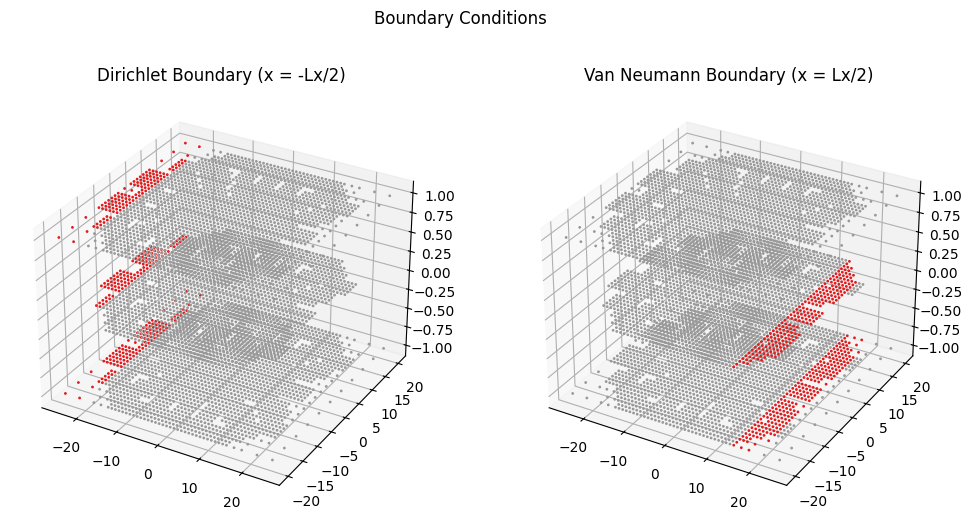

In [41]:
# Lets setup the boundary conditions
def get_boundary_masks(mesh: dict, Lx: float, Lz: float):
    """Get boundary condition masks for the adaptive mesh.

    Args:
        mesh: Dictionary containing 'points' array.
        Lx: Size of the domain in x-direction.
        Lz: Size of the domain in z-direction.

    Returns:
        dirichlet_mask: Boolean array for Dirichlet boundary condition.
        van_neumann_mask: Boolean array for Van Neumann boundary condition.
    """
    pts = mesh["points"]

    dirichlet_mask = pts[:, 0] <= -Lx / 2 + Lx / 10
    van_neumann_mask = jnp.logical_and(
        jnp.isclose(pts[:, 0], (Lx / 2) - Lx / 6, atol=Lx / 16),
        jnp.isclose(pts[:, 2], -Lz / 2, atol=Lz / 2),
    )

    return dirichlet_mask, van_neumann_mask


dirichlet_mask, van_neumann_mask = get_boundary_masks(adaptive_mesh, Lx, Lz)

fig, axs = plt.subplots(1, 2, subplot_kw={"projection": "3d"}, figsize=(12, 6))
# set the colormap to Set1
plt.suptitle("Boundary Conditions")
# remove the axis ticks
colors = jnp.where(dirichlet_mask[: adaptive_mesh["n_points"]], 0.1, 0.2)

pts = adaptive_mesh["points"][: adaptive_mesh["n_points"]]

axs[0].scatter(
    pts[:, 0],
    pts[:, 1],
    pts[:, 2],
    c=jnp.where(dirichlet_mask[: adaptive_mesh["n_points"]], 0.1, 0.2),
    s=1,
    alpha=1.0,
    cmap="Set1",
)
axs[0].set_title("Dirichlet Boundary (x = -Lx/2)")

axs[1].scatter(
    pts[:, 0],
    pts[:, 1],
    pts[:, 2],
    c=jnp.where(van_neumann_mask[: adaptive_mesh["n_points"]], 0.1, 0.2),
    s=1,
    alpha=1.0,
    cmap="Set1",
)
axs[1].set_title("Van Neumann Boundary (x = Lx/2)")

# convert to int arrays for tesseract input
dirichlet_mask = dirichlet_mask.astype(jnp.int32)
van_neumann_mask = van_neumann_mask.astype(jnp.int32)

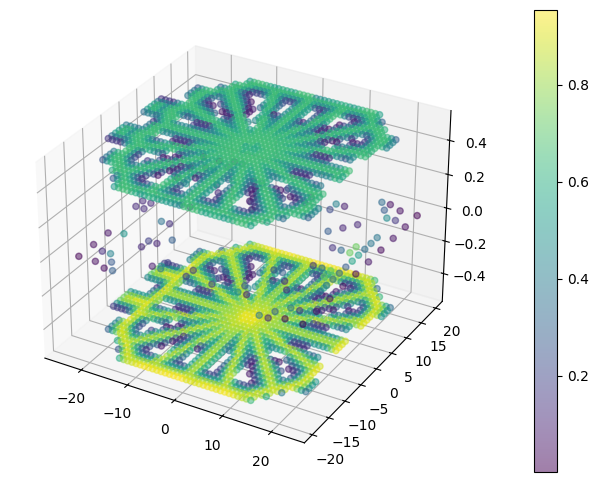

In [42]:
# lets make a scatter plot of the mesh cell values as colors
fig, ax = plt.subplots(1, 1, figsize=(8, 6), subplot_kw={"projection": "3d"})
pts_coords = mesher_out["mesh"]["points"][: mesher_out["mesh"]["n_points"]]
hex_cells = mesher_out["mesh"]["faces"][: mesher_out["mesh"]["n_faces"]]
center_points = jnp.mean(pts_coords[hex_cells], axis=1)
rho_mesh = mesher_out["mesh_cell_values"][: mesher_out["mesh"]["n_faces"]]
scat = ax.scatter(
    center_points[:, 0],
    center_points[:, 1],
    center_points[:, 2],
    c=rho_mesh,
    s=20,
    # alpha=rho+0.3,
    alpha=0.5,
    cmap="viridis",
)
# colorbar
cbar = plt.colorbar(scat, ax=ax, pad=0.1)

In [43]:
fem_tess = Tesseract.from_tesseract_api("fem_tess/tesseract_api.py")

In [44]:
compliance = apply_tesseract(
    fem_tess,
    {
        "rho": jnp.expand_dims(mesher_out["mesh_cell_values"], axis=-1),
        "hex_mesh": adaptive_mesh,
        "dirichlet_mask": dirichlet_mask,
        "dirichlet_values": jnp.array([0.0]),
        "van_neumann_mask": van_neumann_mask,
        "van_neumann_values": jnp.array([[0.0, 0.0, 0.01]]),
    },
)["compliance"]
print(f"Compliance: {compliance:.4f}")

[11-20 16:25:10][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-20 16:25:10][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-20 16:25:10][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)


[11-20 16:25:11][DEBUG] jax_fem: Done pre-computations, took 0.5538394451141357 [s]
[11-20 16:25:11][INFO] jax_fem: Solving a problem with 3258 cells, 5502x3 = 16506 dofs.
[11-20 16:25:11][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-20 16:25:11][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-20 16:25:11][DEBUG] jax_fem: Start timing
[11-20 16:25:11][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-20 16:25:11][DEBUG] jax_fem: Function split_and_compute_cell took 0.2992 seconds
[11-20 16:25:11][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-20 16:25:12][DEBUG] jax_fem: Before, l_2 res = 0.5517109323590015, relative l_2 res = 1.0
[11-20 16:25:12][DEBUG] jax_fem: Solving linear system...
[11-20 16:25:12][DEBUG] jax_fem: Scipy Solver - Solving linear system with UMFPACK
[11-20 16:25:12][DEBUG] jax_fem: Scipy Solver - Finished solving, linear solve res = 3.3655504756326953e-10
[11-20 16:25:12][DEBUG]

Compliance: 6.3010


In [45]:
from typing import TypeVar

T = TypeVar("T")


def stop_grads_int(x: T) -> T:
    """Stops gradient computation.

    We cannot use jax.lax.stop_gradient directly because Tesseract meshes are
    nested dictionaries with arrays and integers, and jax.lax.stop_gradient
    does not support integers.

    Args:
        x: Input value.

    Returns:
        Value with stopped gradients.
    """

    def stop(x):
        return jax._src.ad_util.stop_gradient_p.bind(x)

    return jax.tree_util.tree_map(stop, x)

In [46]:
from jax import custom_vjp

grad_storage = {}


def store_values(x, x_dot, hash_val: int):
    global grad_storage
    print("Storing values in hash", hash_val)
    grad_storage[int(hash_val)] = (x, x_dot)


@custom_vjp
def identity_and_store_grads(x, hash_val: int):
    return x


def identity_fwd(x, hash_val):
    return x, (x, hash_val)


def identity_bwd(residuals, g):
    x, hash_val = residuals
    jax.debug.callback(store_values, x, g, hash_val, ordered=False)
    return (g, None)


identity_and_store_grads.defvjp(identity_fwd, identity_bwd)

In [47]:
@jax.custom_gradient
def gradient_clipping(x):
    return x, lambda g: (jnp.clip(g, -1.0, 1.0))

In [48]:
max_points = 20000
max_cells = 20000


def loss(
    params: jnp.ndarray,
    iteration: int = 0,
) -> tuple[float, dict]:
    """Compute structural compliance for given bar parameters.

    Args:
        params: Geometry parameter array.
        iteration: Current iteration number.

    Returns:
        Structural compliance (scalar). Lower values indicate better performance.
    """
    sdf = identity_and_store_grads(params, iteration + 0)
    design_out = apply_tesseract(
        design_tess,
        {
            "differentiable_parameters": params,
            **design_inputs,
        },
    )

    sdf = design_out["sdf"]

    # sdf = gradient_clipping(sdf)

    sdf = identity_and_store_grads(sdf, iteration + 1000)

    # Convert SDF to material density distribution
    rho_grid = sdf_to_rho(sdf, scale=rho_scale, offset=rho_offset)

    rho_grid = identity_and_store_grads(rho_grid, iteration + 2000)

    sizing = sizing_field(
        sdf, min_size=sizing_min, max_size=sizing_max, scale=sizing_scale
    )

    sizing = jax.lax.stop_gradient(sizing)

    mesher_out = apply_tesseract(
        mesher,
        {
            "domain_size": [Lx, Ly, Lz],
            "sizing_field": sizing,
            # "sizing_field": jnp.ones_like(sdf) * sizing_min,
            "field_values": rho_grid,
            "max_subdivision_levels": 3,
            "max_points": max_points,
            "max_cells": max_cells,
        },
    )

    rho_cell = jnp.expand_dims(mesher_out["mesh_cell_values"], axis=-1)
    print(rho_cell)
    rho_cell = identity_and_store_grads(rho_cell, iteration + 3000)

    mesh = stop_grads_int(mesher_out["mesh"])

    dirichlet_mask, van_neumann_mask = get_boundary_masks(mesh, Lx, Lz)

    van_neumann_mask = jax.lax.stop_gradient(van_neumann_mask)
    dirichlet_mask = jax.lax.stop_gradient(dirichlet_mask)
    dirichlet_values = jnp.array([0.0])
    van_neumann_values = jnp.array([[0.0, 0.0, 0.01]])

    # Instead of passing all inputs and trying to stop_gradient on them,
    # we need to wrap the tesseract call to only allow gradients w.r.t. rho
    c = apply_tesseract(
        fem_tess,
        {
            "rho": rho_cell,
            "hex_mesh": mesh,
            "dirichlet_mask": dirichlet_mask,
            "dirichlet_values": dirichlet_values,
            "van_neumann_mask": van_neumann_mask,
            "van_neumann_values": van_neumann_values,
        },
    )["compliance"]

    # lets store all intermediate results in a dictionary to return
    # for visualization purposes
    surface_mesh = {
        "points": design_out["mesh"]["points"][: design_out["mesh"]["n_points"]],
        "faces": design_out["mesh"]["faces"][: design_out["mesh"]["n_faces"]],
    }

    hex_mesh = {
        "points": mesher_out["mesh"]["points"][: mesher_out["mesh"]["n_points"]],
        "faces": mesher_out["mesh"]["faces"][: mesher_out["mesh"]["n_faces"]],
        "rho": mesher_out["mesh_cell_values"][: mesher_out["mesh"]["n_faces"]],
    }

    return c, {
        "sdf": sdf,
        "rho_grid": rho_grid,
        "rho_cell": rho_cell,
        "sizing": sizing,
        "hex_mesh": hex_mesh,
        "surface_mesh": surface_mesh,
    }

In [49]:
grad_fn = jax.value_and_grad(loss, has_aux=True)

In [50]:
(loss_value, aux), grads = grad_fn(init_diffable_params, iteration=0)
print(f"loss {loss_value}, grads {grads}")

Starting Jacobian precomputation thread...
Done building mesh


[11-20 16:26:45][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-20 16:26:45][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-20 16:26:45][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)


LinearizeTracer<float32[20000,1]>


[11-20 16:26:46][DEBUG] jax_fem: Done pre-computations, took 0.5879061222076416 [s]
[11-20 16:26:46][INFO] jax_fem: Solving a problem with 3258 cells, 5502x3 = 16506 dofs.
[11-20 16:26:46][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-20 16:26:46][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-20 16:26:46][DEBUG] jax_fem: Start timing
[11-20 16:26:46][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-20 16:26:46][DEBUG] jax_fem: Function split_and_compute_cell took 0.2796 seconds
[11-20 16:26:46][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-20 16:26:46][DEBUG] jax_fem: Before, l_2 res = 0.5517109323590015, relative l_2 res = 1.0
[11-20 16:26:46][DEBUG] jax_fem: Solving linear system...
[11-20 16:26:46][DEBUG] jax_fem: Scipy Solver - Solving linear system with UMFPACK
[11-20 16:26:47][DEBUG] jax_fem: Scipy Solver - Finished solving, linear solve res = 3.3082624908595087e-10
[11-20 16:26:47][DEBUG]

Storing values in hash 3000
Done building mesh
Storing values in hash 2000
Storing values in hash 1000
Using precomputed Jacobian...
Waiting for Jacobian precomputation to finish...
Jacobian precomputation finished.
Jacobian shape: (18, 250, 200, 10) and type: float32
loss 6.324466228485107, grads [216.34026   29.526688  47.74082  -14.844203 -28.989788  56.37416
   5.632901  15.456707  92.4792    22.152306 210.90326   45.088642
  67.0428    40.301758  26.92749   26.815462  54.577248  21.116661]


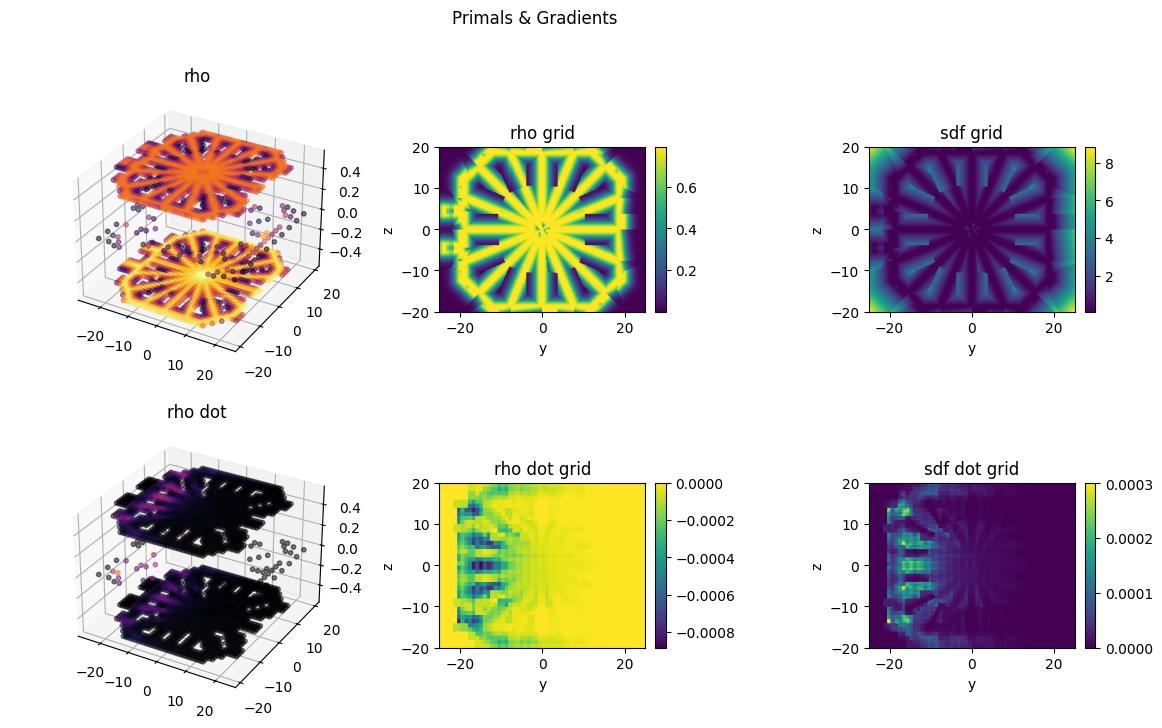

In [51]:
fig, axs = plt.subplots(2, 3, figsize=(14, 8))
plt.suptitle("Primals & Gradients")
axs[0, 0].set_xticks([])
axs[0, 0].set_yticks([])
axs[1, 0].set_xticks([])
axs[1, 0].set_yticks([])

ax = axs[0, 0]
for spine in ax.spines.values():
    spine.set_visible(False)

ax = axs[1, 0]
for spine in ax.spines.values():
    spine.set_visible(False)

# Set the first two subplots to 3D
axs[0, 0] = fig.add_subplot(2, 2, 1, projection="3d")
axs[1, 0] = fig.add_subplot(2, 2, 3, projection="3d")


mesh = aux["hex_mesh"]

pts_coords = mesh["points"]
hex_cells = mesh["faces"]
pts = jnp.mean(pts_coords[hex_cells], axis=1)

axs[0, 0].scatter(
    pts[:, 0],
    pts[:, 1],
    pts[:, 2],
    c=mesh["rho"],
    s=10,
    alpha=0.5,
    cmap="inferno",
)
axs[0, 0].set_title("rho")

axs[1, 0].scatter(
    pts[:, 0],
    pts[:, 1],
    pts[:, 2],
    c=-grad_storage[3000][1][: mesh["rho"].shape[0]],
    s=10,
    alpha=0.5,
    cmap="inferno",
)
axs[1, 0].set_title("rho dot")

plot_grid_slice(
    aux["rho_grid"][:, :, Nz // 2],
    extent=(-Lx / 2, Lx / 2, -Ly / 2, Ly / 2),
    ax=axs[0, 1],
    title="rho grid",
    xlabel="y",
    ylabel="z",
)

plot_grid_slice(
    grad_storage[2000][1][:, :, Nz // 2],
    extent=(-Lx / 2, Lx / 2, -Ly / 2, Ly / 2),
    ax=axs[1, 1],
    title="rho dot grid",
    xlabel="y",
    ylabel="z",
)

plot_grid_slice(
    aux["sdf"][:, :, Nz // 2],
    extent=(-Lx / 2, Lx / 2, -Ly / 2, Ly / 2),
    ax=axs[0, 2],
    title="sdf grid",
    xlabel="y",
    ylabel="z",
)

plot_grid_slice(
    grad_storage[1000][1][:, :, Nz // 2],
    extent=(-Lx / 2, Lx / 2, -Ly / 2, Ly / 2),
    ax=axs[1, 2],
    title="sdf dot grid",
    xlabel="y",
    ylabel="z",
)

fig.subplots_adjust(wspace=0.9)
# fig.tight_layout(w_pad=3.0)

In [ ]:
import optax

n_steps = 10
# strong learning rate decay
schedule = optax.exponential_decay(
    init_value=0.01, transition_steps=n_steps, decay_rate=0.9, staircase=False
)
optmizer = optax.adam(learning_rate=schedule)

params = init_diffable_params.copy()
opt_state = optmizer.init(params)

# params = normalize(init_diffable_params.copy(), normalization_factors)
loss_hist = []
params_hist = []

grad_fn = jax.value_and_grad(loss, has_aux=True)

aux_hist = []

for i in range(n_steps):
    print(params)
    (loss_value, aux), grads = grad_fn(params, iteration=i)

    grads = grads / jnp.max(grads)
    aux_hist.append(aux)

    print(jnp.max(grad_storage[3000 + i][1]))

    print(grads)

    updates, opt_state = optmizer.update(
        grads, opt_state, params, value=loss_value, grad=grads, value_fn=loss
    )
    params = optax.apply_updates(params, updates)

    params = params.at[0:2].set(init_diffable_params[0:2])

    loss_hist.append(loss_value)
    params_hist.append(params)

    print(f"Iteration {i + 1}, Loss: {loss_value:.4f}")

[0.2        0.2        0.         0.49999997 0.0621019  0.56210184
 0.12579617 0.62579614 0.18789807 0.68789804 0.24999999 0.74999994
 0.3121019  0.81369424 0.37579614 0.8757961  0.43789804 0.937898  ]


In [59]:
for i in range(n_steps):
    mesh = aux_hist[i]["hex_mesh"]
    rho_dot = grad_storage[i + 3000][1][: len(mesh["faces"])][:, 0]
    print(mesh["rho"].shape)
    print(rho_dot.shape)
    pv_mesh = hex_to_pyvista(
        mesh["points"], mesh["faces"], {"rho": mesh["rho"], "rho_dot": rho_dot}
    )
    pv_mesh.save(f"vtks/fem_shapeopt_mesh{i + 1}.vtk")

(3258,)
(3258,)
(2861,)
(2861,)
(2871,)
(2871,)
(2725,)
(2725,)
(2734,)
(2734,)
(2735,)
(2735,)
(2662,)
(2662,)
(2762,)
(2762,)
(2648,)
(2648,)
(2797,)
(2797,)
(2912,)
(2912,)
(2947,)
(2947,)
(2848,)
(2848,)
(2832,)
(2832,)
(2864,)
(2864,)
(2906,)
(2906,)
(2832,)
(2832,)
(2873,)
(2873,)
(2824,)
(2824,)
(2797,)
(2797,)
(2870,)
(2870,)
(2811,)
(2811,)
(2906,)
(2906,)
(2948,)
(2948,)
(2899,)
(2899,)
(2885,)
(2885,)
(2825,)
(2825,)
(2788,)
(2788,)
(2822,)
(2822,)
(2826,)
(2826,)


In [76]:
# store intermediate grads as vtks

hex_to_pyvista(pts_np, cells_np, {"rho": mesher_out["mesh_cell_values"]})

UnstructuredGrid (0x7cc14879ece0)
  N Cells:    40000
  N Points:   40000
  X Bounds:   -2.500e+01, 2.500e+01
  Y Bounds:   -2.000e+01, 2.000e+01
  Z Bounds:   -1.000e+00, 1.000e+00
  N Arrays:   1

Text(0.5, 1.0, 'Compliance over Optimization')

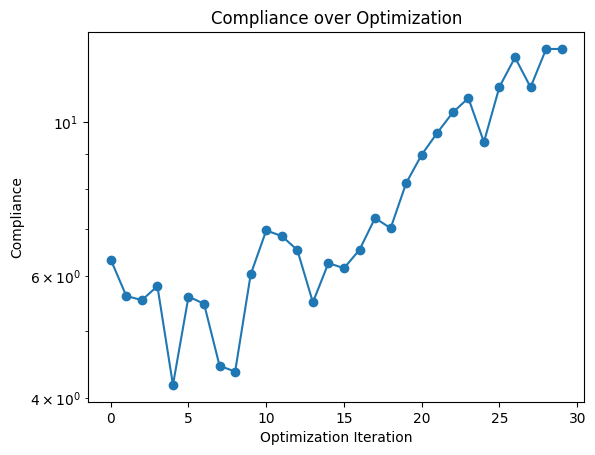

In [57]:
plt.plot(loss_hist, marker="o")
plt.yscale("log")
plt.xlabel("Optimization Iteration")
plt.ylabel("Compliance")
plt.title("Compliance over Optimization")

In [58]:
from matplotlib import animation

# repeat the last frame a few times to show the final result
params_hist = params_hist + [params] * 20

fig = plt.figure(figsize=(7, 4))

design_inputs["precompute_jacobian"] = False

ims = []
for aux in aux_hist:
    sdf = aux["sdf"]

    im = plt.imshow((sdf[:, :, :] > 0).sum(axis=2).T, origin="lower", cmap="viridis")
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=10, blit=False, repeat_delay=2)
plt.close(fig)

ani.save("rho_optim_sum_2.gif", writer="pillow", fps=10)

In [60]:
# lets visualize the 3d meshes over the optimization
for i, aux in enumerate(aux_hist):
    plot_mesh(aux["surface_mesh"], save_path=f"tmp_img/mesh_optim_{i:03d}.png")